# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](https://github.com/silviomori/udacity-deeplearning-nanodegree-fork/blob/silviomori-project-dog-classification/project-dog-classification/images/sample_dog_output.png?raw=1)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dogImages`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home diretcory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [0]:
# Install cv2 library
!pip install -q opencv-python

# Download OpenCV's implementation of Haar feature-based cascade classifiers to detect human faces in images
!wget -q 'https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_alt.xml' -P haarcascades

In [0]:
# Download the dog images
!wget -q https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip -q dogImages.zip

In [0]:
# Download the human images
!wget -q https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip
!unzip -q lfw.zip lfw/*/*

In [0]:
# Import all dependencies for this notebook
%matplotlib inline

import numpy as np
from glob import glob
import cv2
from tqdm import tqdm

import matplotlib.pyplot as plt

from PIL import Image, ImageFile

import torch
from torch import nn, optim
from torchvision import models, transforms, datasets

import sys

from google.colab import drive

In [5]:
gdrive_dir = '/gdrive'
drive.mount(gdrive_dir)
gdrive_dir = gdrive_dir+'/My Drive/Colab Notebooks/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [6]:
# load filenames for human and dog images
human_files = np.array(glob("lfw/*/*"))
dog_files = np.array(glob("dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


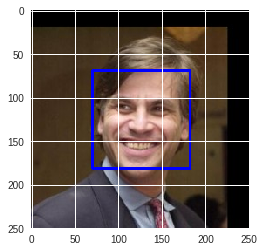

In [7]:
# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [0]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__  
Human faces detected in human images: __```100.0%```__  
Human faces detected in dog images: __```8.0%```__

In [9]:
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## DONE: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

detections_in_human_files = np.mean([face_detector(img) for img in human_files_short]) * 100
print(f'Human faces detected in human images\t{detections_in_human_files:2}%')

detections_in_dog_files = np.mean([face_detector(img) for img in dog_files_short]) * 100
print(f'Human faces detected in dog images\t{detections_in_dog_files:2}%')

Human faces detected in human images	100.0%
Human faces detected in dog images	15.0%


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [0]:
### (Optional) 
### TODO: Test performance of anotherface detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [11]:
# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# set model to evaluation mode
VGG16.eval()

# do not track gradients for the model parameters
for param in VGG16.parameters():
    param.requires_grad = False

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
553433881it [00:17, 31371702.88it/s]


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [0]:
def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## DONE: Complete the function.
    ## Load and pre-process an image from the given img_path
    compose = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    
    image = Image.open(img_path)

    image = compose(image)
    image = image[None,:]
    
    if use_cuda:
        image = image.cuda()
        
    ## Return the *index* of the predicted class for that image
    prediction = VGG16(image)
    
    # predicted class index
    _, top_class = prediction.topk(1)
    return top_class.item()

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [0]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## DONE: Complete the function.
    
    prediction = VGG16_predict(img_path)
    
    # true/false
    return prediction >= 151 and prediction <= 268

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__  
Dogs detected in human images	__```0.0%```__  
Dogs detected in dog images	__```100.0%```__


In [14]:
### DONE: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
detections_in_human_files = np.mean([dog_detector(img) for img in human_files_short]) * 100
print(f'Dogs detected in human images\t{detections_in_human_files:2}%')

detections_in_dog_files = np.mean([dog_detector(img) for img in dog_files_short]) * 100
print(f'Dogs detected in dog images\t{detections_in_dog_files:2}%')

Dogs detected in human images	0.0%
Dogs detected in dog images	100.0%


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [0]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="https://github.com/silviomori/udacity-deeplearning-nanodegree-fork/blob/silviomori-project-dog-classification/project-dog-classification/images/Brittany_02625.jpg?raw=1" width="100"> | <img src="https://github.com/silviomori/udacity-deeplearning-nanodegree-fork/blob/silviomori-project-dog-classification/project-dog-classification/images/Welsh_springer_spaniel_08203.jpg?raw=1" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="https://github.com/silviomori/udacity-deeplearning-nanodegree-fork/blob/silviomori-project-dog-classification/project-dog-classification/images/Curly-coated_retriever_03896.jpg?raw=1" width="200"> | <img src="https://github.com/silviomori/udacity-deeplearning-nanodegree-fork/blob/silviomori-project-dog-classification/project-dog-classification/images/American_water_spaniel_00648.jpg?raw=1" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="https://github.com/silviomori/udacity-deeplearning-nanodegree-fork/blob/silviomori-project-dog-classification/project-dog-classification/images/Labrador_retriever_06457.jpg?raw=1" width="150"> | <img src="https://github.com/silviomori/udacity-deeplearning-nanodegree-fork/blob/silviomori-project-dog-classification/project-dog-classification/images/Labrador_retriever_06455.jpg?raw=1" width="240"> | <img src="https://github.com/silviomori/udacity-deeplearning-nanodegree-fork/blob/silviomori-project-dog-classification/project-dog-classification/images/Labrador_retriever_06449.jpg?raw=1" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [16]:
### DONE: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

# avoid PIL to raise exception if find a truncated image
ImageFile.LOAD_TRUNCATED_IMAGES = True

# folder where the images are
data_dir = 'dogImages/'

# how many subprocesses to use for data loading
num_workers = 0 # data will be loaded in the main thread

# arrays to normalization
normalize_mean = np.array([0.485, 0.456, 0.406])
normalize_std = np.array([0.229, 0.224, 0.225])

## Specify transforms
data_transforms = {}

# transforms to train data set
data_transforms['train'] = transforms.Compose([
    transforms.Resize(480),
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224, scale=(224./480, 224./256), ratio=(1.,1.)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(
        normalize_mean,
        normalize_std)
    ])

# transforms to valid data set
data_transforms['valid_test'] = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        normalize_mean,
        normalize_std)
    ])

## Load the datasets with ImageFolder
image_datasets = {}
image_datasets['train_data'] = datasets.ImageFolder(data_dir + '/train', transform=data_transforms['train'])
image_datasets['valid_data'] = datasets.ImageFolder(data_dir + '/valid', transform=data_transforms['valid_test'])
image_datasets['test_data'] = datasets.ImageFolder(data_dir + '/test', transform=data_transforms['valid_test'])

## Using the image datasets and the transforms, define the dataloaders
dataloaders = {}
dataloaders['train_data'] = torch.utils.data.DataLoader(image_datasets['train_data'], batch_size=96,  shuffle=True, num_workers=num_workers)
dataloaders['valid_data'] = torch.utils.data.DataLoader(image_datasets['valid_data'], batch_size=167, shuffle=False, num_workers=num_workers)
dataloaders['test_data']  = torch.utils.data.DataLoader(image_datasets['test_data'],  batch_size=64,  shuffle=False, num_workers=num_workers)

print(f"Train data: {len(dataloaders['train_data'].dataset)} images / {len(dataloaders['train_data'])} batches")
print(f"Valid data: {len(dataloaders['valid_data'].dataset)} images / {len(dataloaders['valid_data'])} batches")
print(f"Test  data: {len(dataloaders['test_data'].dataset) } images / {len(dataloaders['test_data']) } batches")

Train data: 6680 images / 70 batches
Valid data: 835 images / 5 batches
Test  data: 836 images / 14 batches


**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:  

__Image size__  
I choose to work with an input image of 224x224 pixels which allows me to perform five downsizings (stride = 2), resulting in a 7x7 tensor at the end of the convolutional layers.  

__Resizing the image__  
To obtain the 224x224 pixels input image I perform the following steps:  

_For the training data set:_
- Resize the image making its smaller side 480 px, keeping the original aspect ratio.
- Make a random crop of 224x224 px, with a scale in the range [224/480, 224/256], maintaining the original aspect ratio. Making the crop in this way is the same as resizing the smaller side of the input image to the range [256, 480] px before performing the 224x224 px crop.  

_For the validation and testing data set:_
- Resize the image making its smaller edge 224 px, keeping the original aspect ratio.
- Make a center crop of 224x224px, maintaining the original aspect ratio.

__Data augmentation__  
I build my data augmentation method based on that found in the ResNet paper. _(Only for the training data set)._
- Translations: I make a random crop of 224x224 px in the resized original image. The original image is resized with its shorter side randomly sampled in the range [256, 480] px.
- Flips: A horizontal flip has a 50% chance of being performed.
- Rotations: The image is rotated in a range of [+30, -30] degrees.

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [0]:
# define the CNN architecture
class Net(nn.Module):
    ### DONE: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        
        ## Convolutional layers
        # in: 224x224    out: 112x112
        self.conv1    = nn.Conv2d(    3,  64, 7, padding=3, stride=2)
        self.conv1_bn = nn.BatchNorm2d(   64)
        
        # in: 112x112    out: 56x56
        self.conv2_1    = nn.Conv2d( 64,  64, 3, padding=1)
        self.conv2_1_bn = nn.BatchNorm2d( 64)
        self.conv2_2    = nn.Conv2d( 64,  64, 3, padding=1)
        self.conv2_2_bn = nn.BatchNorm2d( 64)
        
        # in: 56x56    out: 28x28
        self.conv3_in   = nn.Conv2d( 64, 128, 1, padding=1)
        self.conv3_1    = nn.Conv2d(128, 128, 3, padding=1)
        self.conv3_1_bn = nn.BatchNorm2d(128)
        self.conv3_2    = nn.Conv2d(128, 128, 3, padding=1)
        self.conv3_2_bn = nn.BatchNorm2d(128)
        
        # in: 28x28    out: 14x14
        self.conv4_in   = nn.Conv2d(128, 256, 1, padding=1)
        self.conv4_1    = nn.Conv2d(256, 256, 3, padding=1)
        self.conv4_1_bn = nn.BatchNorm2d(256)
        self.conv4_2    = nn.Conv2d(256, 256, 3, padding=1)
        self.conv4_2_bn = nn.BatchNorm2d(256)
        
        # in: 14x14    out: 7x7
        self.conv5_in   = nn.Conv2d(256, 512, 1, padding=1)
        self.conv5_1    = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_1_bn = nn.BatchNorm2d(512)
        self.conv5_2    = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_2_bn = nn.BatchNorm2d(512)
        
        # Downsizing
        self.maxpool = nn.MaxPool2d(          3, padding=1, stride=2)
        
        # in: 7x7    out: 1x1
        self.avgpool = nn.AvgPool2d(7)
        
        # Activation
        self.activation = nn.ReLU()
        
        # Fully connected layers
        self.fc = nn.Linear(512,133)
                                
        
    def forward(self, x):
        ## Define forward behavior
        
        ## Stack 1
        x = self.conv1(x)
        x = self.conv1_bn(x)
        x = self.activation(x)
        
        ## Stack 2
        shortcut = x
        
        x = self.conv2_1(x)
        x = self.conv2_1_bn(x)
        x = self.activation(x)
        
        x = self.conv2_2(x)
        x = self.conv2_2_bn(x)
        x = self.activation(x)
        
        x += shortcut
            
        x = self.maxpool(x)
        
        ## Stack 3
        x = self.conv3_in(x)
        x = self.activation(x)
        
        shortcut = x
        
        x = self.conv3_1(x)
        x = self.conv3_1_bn(x)
        x = self.activation(x)
        
        x = self.conv3_2(x)
        x = self.conv3_2_bn(x)
        x = self.activation(x)
        
        x += shortcut
        
        x = self.maxpool(x)
        
        ## Stack 4
        x = self.conv4_in(x)
        x = self.activation(x)
        
        shortcut = x
        
        x = self.conv4_1(x)
        x = self.conv4_1_bn(x)
        x = self.activation(x)
        
        x = self.conv4_2(x)
        x = self.conv4_2_bn(x)
        x = self.activation(x)
        
        x += shortcut
        
        x = self.maxpool(x)
        
        ## Stack 5
        x = self.conv5_in(x)
        x = self.activation(x)
        
        shortcut = x
        
        x = self.conv5_1(x)
        x = self.conv5_1_bn(x)
        x = self.activation(x)
        
        x = self.conv5_2(x)
        x = self.conv5_2_bn(x)
        x = self.activation(x)
        
        x += shortcut
            
        x = self.maxpool(x)
        
        x = self.avgpool(x)
        
        # Classifier
        x = x.squeeze()
        x = self.fc(x)
        
        return x

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
use_cuda = torch.cuda.is_available()
if use_cuda:
    model_scratch.cuda()

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__  

_That is not my final CNN architecture yet; just testing some possibilities._  

This CNN architecture is inspired by ResNet paper.  

The first convolutional stack has 64 filters, 7x7 wide each, with a stride of 2.  

Following stacks double the number of filters and reduce the input size by half. The last stack produces 512 filters, 7x7 wide each one.  

1x1 layers are responsible for the increase in the number of filters.  
Max-pooling layers with a stride of 2 are responsible for the decrease in the dimensions of the filters.  
Batch normalization is used to avoid vanishing/exploding gradients.  

The main characteristic of this architecture is the use of __shortcuts__.  
Each stack has a shortcut between the input and the output.  
After applying the activation function, the stack output receives the shortcut. Thus, the output of each stack is: y = f(x) + x.  
Shortcuts expedite network training, allowing a deeper network design.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [0]:
### DONE: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### DONE: select optimizer
optimizer_scratch = optim.Adagrad(model_scratch.parameters(), lr=0.01, weight_decay=0.001)

scheduler_scratch = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_scratch, mode='min', factor=0.1, patience=14, verbose=True,
    threshold=0.01, threshold_mode='abs', cooldown=0, min_lr=0, eps=1e-08)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [0]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda,
          save_path, lr_scheduler=None):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    # define how much epochs to train before run the validation loop
    validate_for_each = 1
    validate_after = 5
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(dataloaders['train_data']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
                
            ## find the loss and update the model parameters accordingly
            # clear optimizer
            optimizer.zero_grad()
            
            # pass train batch through model feed-forward
            output = model(data)
            
            # calculate the loss fr this train batch
            loss = criterion(output, target)
            
            # do the backpropagation
            loss.backward()
            
            # optimize weights
            optimizer.step()
            
            ## record the average training loss
            train_loss += (1 / (batch_idx + 1)) * (loss.item() - train_loss)
            
            sys.stdout.write(f'\rEpoch: {epoch} '+
                             f'\tTraining Loss: {train_loss:.6f} '+
                             f'\tbatchs: {batch_idx+1}')
            
        ######################    
        # validate the model #
        ######################
        if epoch > validate_after and epoch % validate_for_each == 0:
            model.eval()
            with torch.no_grad():
                for batch_idx, (data, target) in enumerate(dataloaders['valid_data']):
                    # move to GPU
                    if use_cuda:
                        data, target = data.cuda(), target.cuda()
                        
                    # get predictions for this validation batch
                    output = model(data)
                    
                    ## update the average validation loss
                    # calculate loss for this validation batch
                    loss = criterion(output, target)
                    # Track validation loss
                    valid_loss += (1 / (batch_idx + 1)) * (loss.item() - valid_loss)
                    
                    sys.stdout.write(f'\rEpoch: {epoch} '+
                                     f'\tTraining Loss: {train_loss:.6f} '+
                                     f'\tValidation Loss: {valid_loss:.6f} '+
                                     f'\tbatchs: {batch_idx+1}')
                    
                # print training/validation statistics 
                print(f'\rEpoch: {epoch} '+
                      f'\tTraining Loss: {train_loss:.6f} '+
                      f'\tValidation Loss: {valid_loss:.6f}')
                
                if lr_scheduler:
                    lr_scheduler.step(valid_loss)
                    
            ## DONE: save the model if validation loss has decreased
            if valid_loss < valid_loss_min:
                print(f'\t\t\tValid loss decreasing: '+
                      f'{valid_loss_min:.6f} --> {valid_loss:.6f} ... Saving model')

                checkpoint = {'model_state_dict': model.state_dict(),
                              'optimizer_state_dict': optimizer.state_dict(),
                              'valid_loss_min': valid_loss_min,
                              'train_loss': train_loss}
                torch.save(checkpoint, save_path)

                valid_loss_min = valid_loss
        else:
            print(f'\rEpoch: {epoch} '+
                  f'\tTraining Loss: {train_loss:.6f}')
            
    # return trained model
    return model

In [0]:
# train the model
checkpoint_path = gdrive_dir+'model_scratch.pt'

model_scratch = train(125, dataloaders, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, checkpoint_path, scheduler_scratch)

Epoch: 1 	Training Loss: 4.936121
Epoch: 2 	Training Loss: 4.641235
Epoch: 3 	Training Loss: 4.385031
Epoch: 4 	Training Loss: 4.225672
Epoch: 5 	Training Loss: 4.132686
Epoch: 6 	Training Loss: 4.026400
Epoch: 7 	Training Loss: 3.938482
Epoch: 8 	Training Loss: 3.832622
Epoch: 9 	Training Loss: 3.734075
Epoch: 10 	Training Loss: 3.632342
Epoch: 11 	Training Loss: 3.533831
Epoch: 12 	Training Loss: 3.440946
Epoch: 13 	Training Loss: 3.326146
Epoch: 14 	Training Loss: 3.235063
Epoch: 15 	Training Loss: 3.152582
Epoch: 16 	Training Loss: 3.047827
Epoch: 17 	Training Loss: 2.962177
Epoch: 18 	Training Loss: 2.872804
Epoch: 19 	Training Loss: 2.814906
Epoch: 20 	Training Loss: 2.729998
Epoch: 21 	Training Loss: 2.670357
Epoch: 22 	Training Loss: 2.602905
Epoch: 23 	Training Loss: 2.509370
Epoch: 24 	Training Loss: 2.442017
Epoch: 25 	Training Loss: 2.377395
Epoch: 26 	Training Loss: 2.317353
Epoch: 27 	Training Loss: 2.254175
Epoch: 28 	Training Loss: 2.174590
Epoch: 29 	Training Loss: 2.0

In [0]:
# load the model that got the best validation accuracy
checkpoint = torch.load(checkpoint_path)
model_scratch.load_state_dict(checkpoint['model_state_dict'])
optimizer_scratch.load_state_dict(checkpoint['optimizer_state_dict'])

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [0]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    
    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test_data']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
        
    print('Test Loss: {:.6f}\n'.format(test_loss))
    
    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [0]:
# call test function    
test(dataloaders, model_scratch, criterion_scratch, use_cuda)

---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [0]:
## DONE: Specify data loaders
# I have decided to use the same data loaders from the previous step.
# Doing this way, I can compare results from my network from scratch
# with the results from transfer learning.

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [19]:
## DONE: Specify model architecture 
model_transfer = models.resnet152(pretrained=True)

# do not track gradients for the model parameters
for param in model_transfer.parameters():
    param.requires_grad = False
    
fc_in_features = model_transfer.fc.in_features
fc_out_classes = 133

model_transfer.fc = nn.Linear(fc_in_features, fc_out_classes, bias=True)

if use_cuda:
    model_transfer = model_transfer.cuda()

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.torch/models/resnet152-b121ed2d.pth
241530880it [00:03, 60845425.06it/s]


__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [0]:
### DONE: select loss function
criterion_transfer = nn.CrossEntropyLoss()

### DONE: select optimizer
optimizer_transfer = optim.Adagrad(model_transfer.fc.parameters(), lr=0.01, weight_decay=0.001)

scheduler_transfer = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_transfer, mode='min', factor=0.1, patience=9, verbose=True,
    threshold=0.01, threshold_mode='abs', cooldown=0, min_lr=0, eps=1e-08)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [21]:
# train the model
checkpoint_path = gdrive_dir+'model_transfer.pt'

model_transfer = train(30, dataloaders, model_transfer, optimizer_transfer,
                       criterion_transfer, use_cuda, checkpoint_path, scheduler_transfer)

Epoch: 1 	Training Loss: 3.256579
Epoch: 2 	Training Loss: 0.815263
Epoch: 3 	Training Loss: 0.623647
Epoch: 4 	Training Loss: 0.528101
Epoch: 5 	Training Loss: 0.470667
Epoch: 6 	Training Loss: 0.430035 	Validation Loss: 0.443151
			Valid loss decreasing: inf --> 0.443151 ... Saving model
Epoch: 7 	Training Loss: 0.395211 	Validation Loss: 0.423346
			Valid loss decreasing: 0.443151 --> 0.423346 ... Saving model
Epoch: 8 	Training Loss: 0.377730 	Validation Loss: 0.420708
			Valid loss decreasing: 0.423346 --> 0.420708 ... Saving model
Epoch: 9 	Training Loss: 0.360075 	Validation Loss: 0.396863
			Valid loss decreasing: 0.420708 --> 0.396863 ... Saving model
Epoch: 10 	Training Loss: 0.336730 	Validation Loss: 0.387565
			Valid loss decreasing: 0.396863 --> 0.387565 ... Saving model
Epoch: 11 	Training Loss: 0.333372 	Validation Loss: 0.381072
			Valid loss decreasing: 0.387565 --> 0.381072 ... Saving model
Epoch: 12 	Training Loss: 0.315687 	Validation Loss: 0.382146
Epoch: 13 	Trai

In [24]:
# load the model that got the best validation accuracy (uncomment the line below)

checkpoint = torch.load(checkpoint_path)

print('Loading trained model ...\tTraining Loss: {}\t Valid Loss: {}'.format(
        checkpoint['train_loss'], checkpoint['valid_loss_min'] ))

model_transfer.load_state_dict(checkpoint['model_state_dict'])
optimizer_transfer.load_state_dict(checkpoint['optimizer_state_dict'])

Loading trained model ...	Training Loss: 0.23479988702705923	 Valid Loss: 0.34389630556106565


### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [23]:
test(dataloaders, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.376617


Test Accuracy: 89% (746/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [0]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in data_transfer['train'].classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    return None

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](https://github.com/silviomori/udacity-deeplearning-nanodegree-fork/blob/silviomori-project-dog-classification/project-dog-classification/images/sample_human_output.png?raw=1)


### (IMPLEMENTATION) Write your Algorithm

In [0]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    


---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

In [0]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
for file in np.hstack((human_files[:3], dog_files[:3])):
    run_app(file)